In [ ]:
# tensorflow 버전 확인

import tensorflow as tf

tf.__version__

'2.15.0'

In [ ]:
# 압축파일 해제

from zipfile import ZipFile

with ZipFile('intel-image-classification.zip') as z:
    z.extractall()

In [ ]:
!ls

gdrive	intel-image-classification.zip	sample_data  seg_pred  seg_test  seg_train


In [ ]:
# dataset을 내 구글 드라이버로 이동시킴
!mv seg_pred /content/drive/MyDrive/Intel\ Image\ Classification/
!mv seg_test /content/drive/MyDrive/Intel\ Image\ Classification/
!mv seg_train /content/drive/MyDrive/Intel\ Image\ Classification/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 다운로드 받았던 파일 제거
!rm intel-image-classification.zip

In [ ]:
# 구글 드라이버로 이동된 dataset 확인
!ls /content/drive/MyDrive/Intel\ Image\ Classification//seg_train/seg_train

buildings  forest  glacier  mountain  sea  street


In [ ]:
%cd /content/drive/MyDrive/Intel Image Classification

!unzip -qq "/content/drive/MyDrive/Intel Image Classification/seg.zip"

/content/drive/MyDrive/Intel Image Classification


In [ ]:
# 필요한 패키지와 모듈을 불러옴
import math
import os
import cv2
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,       # 픽셀 값을 0~1 범위로 변환
    rotation_range=40,    # 40도까지 무작위로 회전
    width_shift_range=0.2,# 20%까지 수평으로 이동
    height_shift_range=0.2,# 20%까지 수직으로 이동
    shear_range=0.2,      # 20%까지 전단 변환 적용
    zoom_range=0.2,       # 20%까지 확대/축소
    horizontal_flip=True, # 좌우 반전 적용
    fill_mode='nearest'   # 회전 또는 폭/높이 이동으로 인해 새롭게 생성되는 픽셀을 채우는 방법
)

In [ ]:
# train_datagen 인스턴스를 통해 trin dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 train_generator 객체를 생성한다
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Intel Image Classification/seg_trian',
    batch_size=20,      # Size of the batches of data (default: 32).
    class_mode='sparse', # Determines the type of label arrays that are returned. "sparse" will be 1D integer labels
    target_size=(150, 150))  # 이미지의 크기 재정의

Found 4134 images belonging to 6 classes.


In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255,       # 픽셀 값을 0~1 범위로 변환
    rotation_range=40,    # 40도까지 무작위로 회전
    width_shift_range=0.2,# 20%까지 수평으로 이동
    height_shift_range=0.2,# 20%까지 수직으로 이동
    shear_range=0.2,      # 20%까지 전단 변환 적용
    zoom_range=0.2,       # 20%까지 확대/축소
    horizontal_flip=True, # 좌우 반전 적용
    fill_mode='nearest'   # 회전 또는 폭/높이 이동으로 인해 새롭게 생성되는 픽셀을 채우는 방법
)

In [ ]:
# ImageDataGenerator를 통해 validation dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 test_generator 객체를 생성한다.
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Intel Image Classification/seg_test',
    batch_size=20,
    class_mode='sparse',
    target_size=(150, 150))

Found 1673 images belonging to 6 classes.


In [ ]:
# test_generator 가 만들어 내는 이미지의 클래스 인덱스가 무엇인지 확인해 본다.
print(test_generator.class_indices)

{'GERUSAM': 0, 'HURIX': 1, 'KIMORAL': 2, 'LIDAN': 3, 'MYARM': 4, 'SEPTRIN': 5}


In [ ]:
# label name 을 찾아 오는 함수를 정의한다.
def findKey(indices, search_value):
    for key, value in indices.items():
        if(value == search_value):
            return key
    return -1

Found 4134 images belonging to 6 classes.


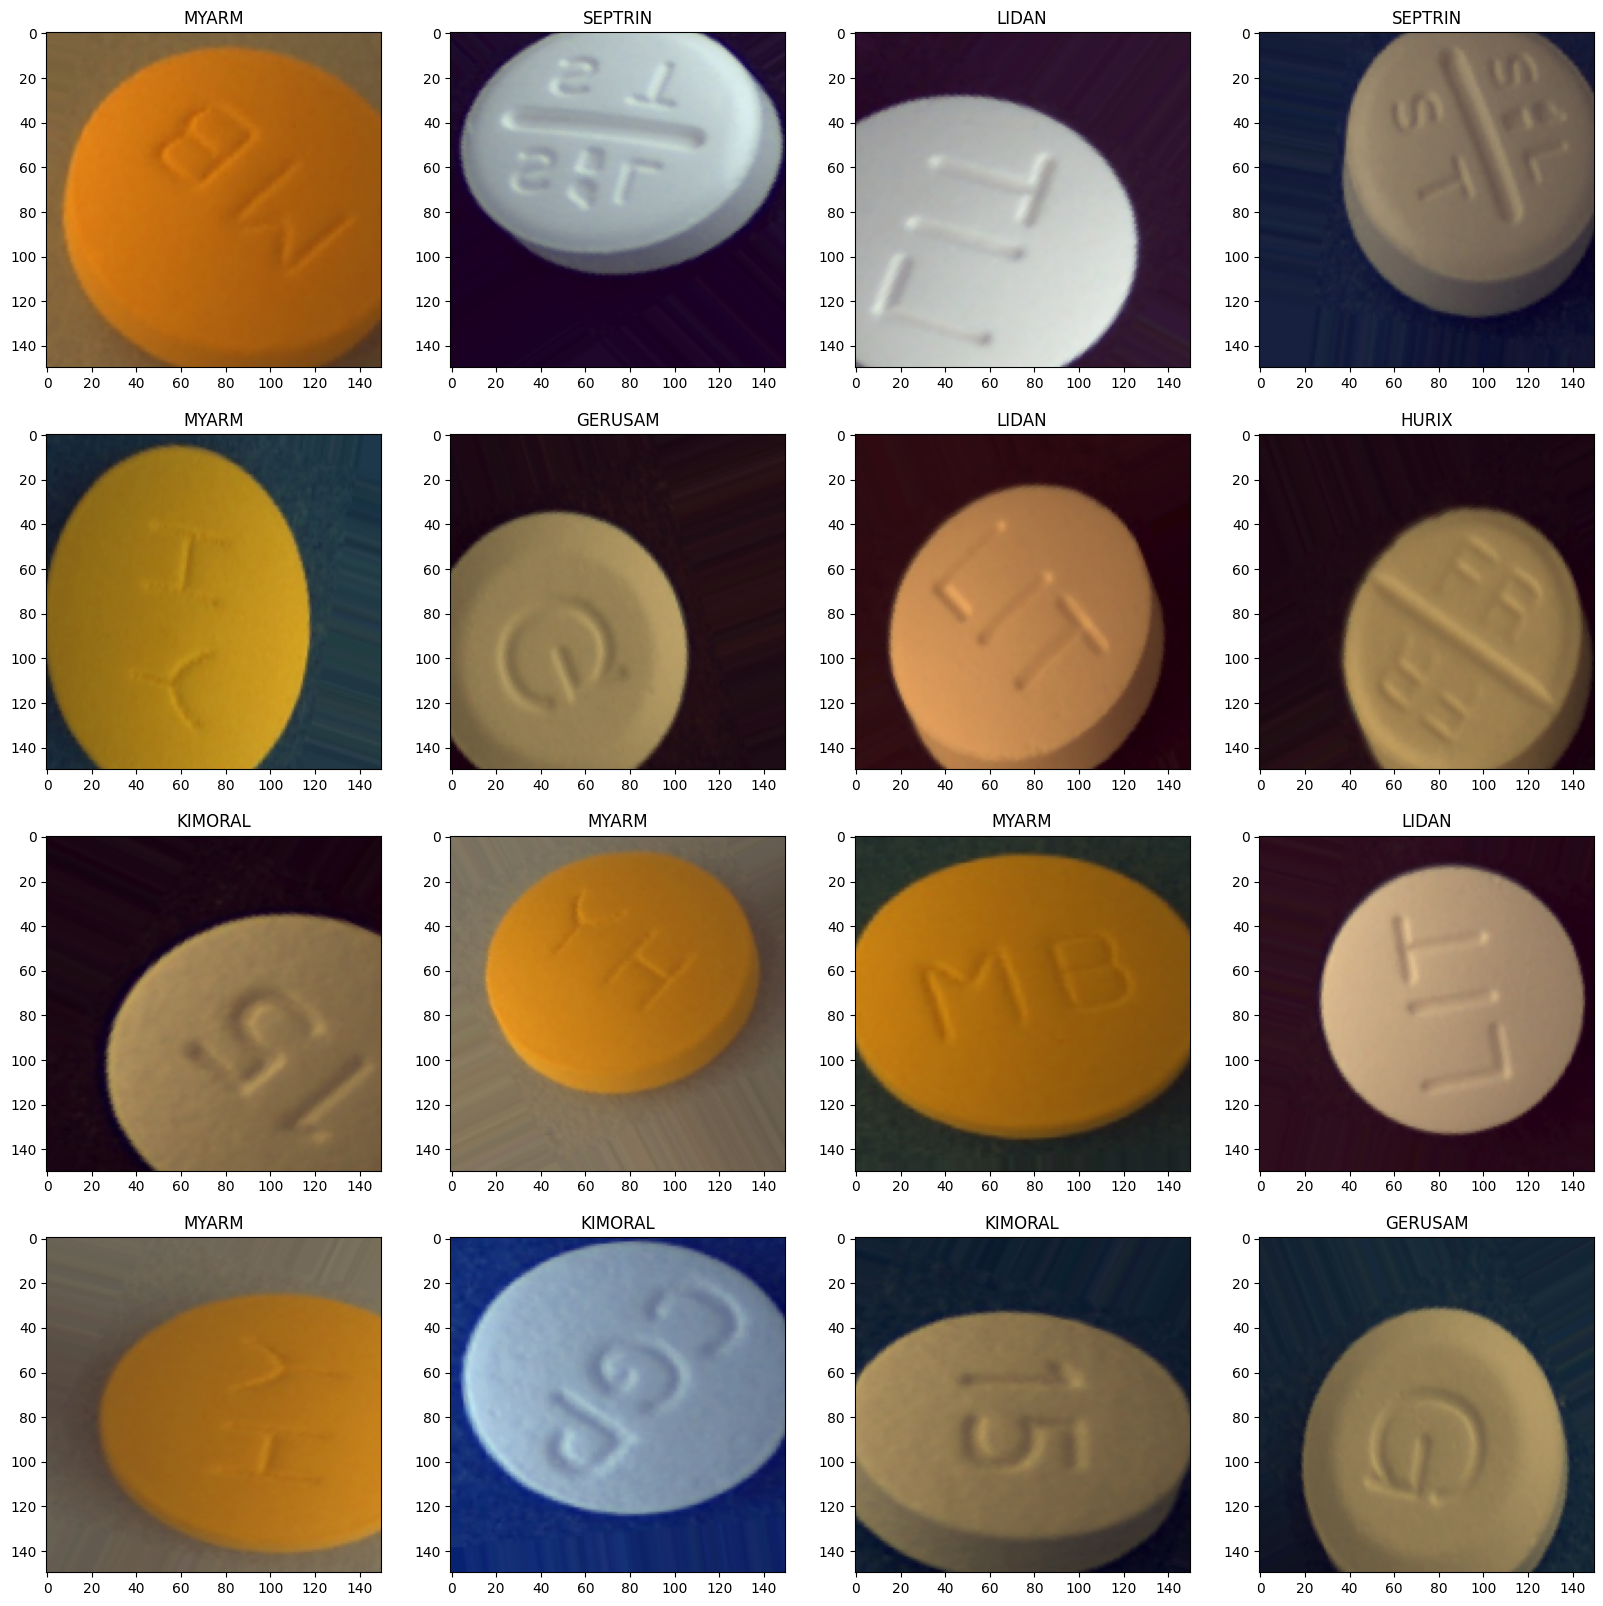

In [ ]:
# training dataset 에서 샘플 데이터를 display 해본다
for X_batch, y_batch in train_datagen.flow_from_directory('/content/drive/MyDrive/Intel Image Classification/seg_trian',
                                                          batch_size=100, class_mode='sparse', target_size=(150, 150)):
    plt.figure(figsize=(20,20))
    # create a grid of 4x4 images
    for i in range(0, 16):
        ax = plt.subplot(4, 4, i+1)
        ax.set_title(findKey(train_generator.class_indices, y_batch[i]))   # 이미지의 label name 을 찾아온다
        plt.imshow((X_batch[i].reshape(150, 150, 3)*255).astype(np.uint8)) # train 샘플 이미지를 보여준다.
    # show the plot
    plt.show()
    break

In [ ]:
# create model(모델을 만듭니다)
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), name="conv1"))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', name="conv2"))
model.add(MaxPooling2D(pool_size=(3, 3), name="maxpool1"))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name="conv3"))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name="conv4"))
model.add(MaxPooling2D(pool_size=(3, 3), name="maxpool2"))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name="conv5"))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name="conv6"))
model.add(MaxPooling2D(pool_size=(3, 3), name="maxpool3"))
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 148, 148, 64)      1792      
                                                                 
 conv2 (Conv2D)              (None, 146, 146, 64)      36928     
                                                                 
 maxpool1 (MaxPooling2D)     (None, 48, 48, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 46, 46, 128)       73856     
                                                                 
 conv4 (Conv2D)              (None, 44, 44, 128)       147584    
                                                                 
 maxpool2 (MaxPooling2D)     (None, 14, 14, 128)       0         
                                                                 
 conv5 (Conv2D)              (None, 12, 12, 256)      

In [ ]:
# model training(모델을 학습시킵니다)
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=140,
                    epochs=40,
                    validation_data=test_generator,
                    validation_steps=30)

<ipython-input-26-bc31cfec47d8>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/40
140/140 [==============================] - 49s 305ms/step - loss: 2.7462 - accuracy: 0.4266 - val_loss: 2.2433 - val_accuracy: 0.4483
Epoch 2/40
140/140 [==============================] - 38s 272ms/step - loss: 2.0329 - accuracy: 0.4714 - val_loss: 1.9443 - val_accuracy: 0.3883
Epoch 3/40
140/140 [==============================] - 37s 262ms/step - loss: 1.7590 - accuracy: 0.4832 - val_loss: 1.6953 - val_accuracy: 0.4167
Epoch 4/40
140/140 [==============================] - 39s 275ms/step - loss: 1.5926 - accuracy: 0.4950 - val_loss: 1.6468 - val_accuracy: 0.4267
Epoch 5/40
140/140 [==============================] - 36s 259ms/step - loss: 1.4875 - accuracy: 0.5271 - val_loss: 1.5385 - val_accuracy: 0.4567
Epoch 6/40
140/140 [==============================] - 40s 284ms/step - loss: 1.3465 - accuracy: 0.5970 - val_loss: 1.4340 - val_accuracy: 0.4817
Epoch 7/40
140/140 [==============================] - 38s 274ms/step - loss: 1.2504 - accuracy: 0.6217 - val_loss: 1.4717 - val_ac

In [ ]:
# model evaluate(모델을 평가해 봅니다)
score = model.evaluate(test_generator, steps=30, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

Test loss: 1.6267064809799194
Test accuracy: 67.166668176651


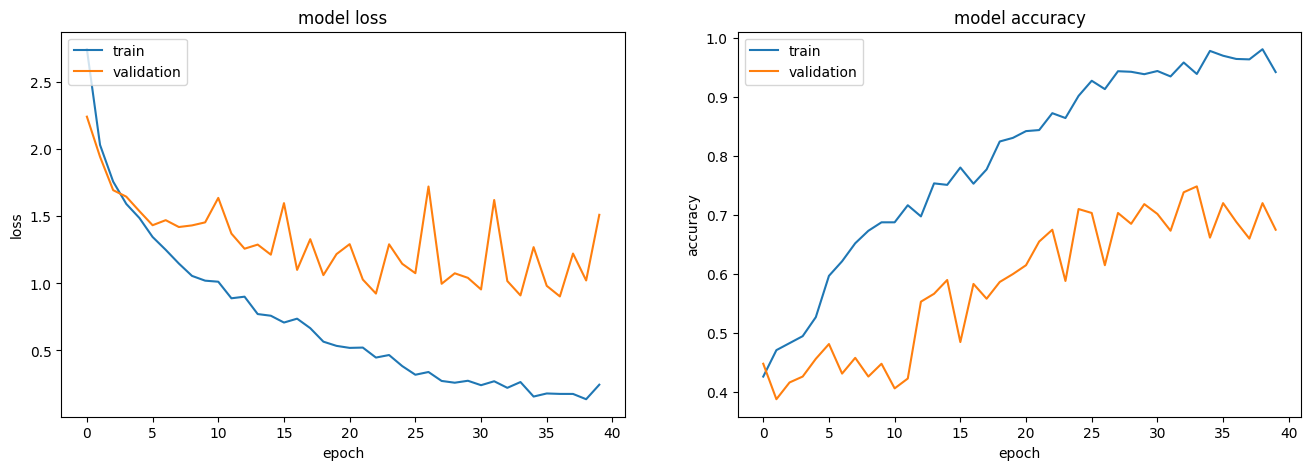

In [ ]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
# 전체 모델을 H5 파일로 저장합니다
model.save('Intel_image_classification_model.h5')
print("Saved model to disk")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk


In [ ]:
# 전체 학습된 모델을 H5파일로 저장하고, 그 파일을 내 구글 드라이버로 이동시킴
!mv Intel_image_classification_model.h5 /content/drive/MyDrive

In [ ]:
# 저장해된 모델을 읽어온다.

from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Intel_image_classification_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 148, 148, 64)      1792      
                                                                 
 conv2 (Conv2D)              (None, 146, 146, 64)      36928     
                                                                 
 maxpool1 (MaxPooling2D)     (None, 48, 48, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 46, 46, 128)       73856     
                                                                 
 conv4 (Conv2D)              (None, 44, 44, 128)       147584    
                                                                 
 maxpool2 (MaxPooling2D)     (None, 14, 14, 128)       0         
                                                                 
 conv5 (Conv2D)              (None, 12, 12, 256)      

In [ ]:
# 디렉토리에서 이미지 파일들을 읽어오는 함수 정의
def get_images(directory):
    Images = []
    pred_img_cnt = 25  # 예측할 이미지를 몇개 불러 올 것인지 설정
    i = 0
    for image_file in os.listdir(directory):          # 디렉토리로부터 파일을 하나하나 불러 온다
        i += 1
        if i > pred_img_cnt: break
        else:
             image = cv2.imread(directory+r'/'+image_file) # 불러온 이미지를 openCV 로 읽어 들인다
             image = cv2.resize(image,(150,150))           # 이미지 크기 재조정
             Images.append(image)

    return Images

In [ ]:
# 예측 할 이미지를 불러온다
pred_images = get_images('/content/drive/MyDrive/Intel Image Classification/seg_pred')
pred_images = np.array(pred_images) * 1./255
pred_images.shape                             # (이미지수, 세로(H), 가로(W), 채널(C))

(25, 150, 150, 3)

In [ ]:
# 예측할 이미지를 우리가 만든 모델을 통해 분류 예측해 봅니다.
prediction = model.predict(pred_images, verbose=1)

1/1 [==============================] - 1s 1s/step


In [ ]:
# 예측한 결과 객체 prediction shape 확인
prediction.shape

(25, 6)

In [ ]:
# 예측한 결과 객체 prediction 값 확인
prediction
#array([[7.01735616e-01, 2.82877952e-01, 6.54686708e-04, 1.84405053e-05, 9.91014822e-05, 1.46140968e-02],
#       [1.85270518e-01, 1.84901670e-04, 1.17759919e-05, 6.83128178e-07, 1.72170112e-05, 8.14514935e-01],
#       [1.34450952e-02, 2.03393437e-02, 2.66767085e-01, 5.47533333e-01, 1.33954734e-01, 1.79604013e-02],
#       [3.71958071e-04, 1.58283790e-03, 2.88972765e-01, 4.06801760e-01, 2.83311099e-01, 1.89595241e-02],
#       [3.52260517e-03, 9.94061353e-04, 6.41896841e-05, 9.30431634e-06, 4.10714256e-06, 9.95405674e-01],
#       [5.69388590e-07, 9.99997497e-01, 1.28447152e-06, 1.60010856e-07, 1.44987062e-08, 5.18240427e-07],
#       [9.77528274e-01, 2.22538393e-02, 2.75015427e-05, 1.55774799e-07, 1.07141068e-06, 1.89180617e-04],
#       [2.17310160e-01, 3.41707258e-03, 5.60939405e-03, 1.14200008e-03, 1.89870608e-03, 7.70622671e-01],
#       [2.98322109e-03, 4.10983717e-04, 2.44892053e-02, 4.61837620e-01, 5.05038023e-01, 5.24095725e-03],

array([[1.49039315e-05, 5.53010204e-06, 9.50395588e-06, 9.99786794e-01,
        6.75427373e-06, 1.76566507e-04],
       [9.07292997e-04, 1.50796073e-03, 1.54297112e-03, 9.87593830e-01,
        6.26330089e-04, 7.82164931e-03],
       [9.93006397e-04, 1.76886679e-03, 1.57570571e-03, 9.87041235e-01,
        6.36289071e-04, 7.98489526e-03],
       [8.50524812e-05, 3.22577544e-05, 3.58488724e-05, 9.99653816e-01,
        9.46603450e-06, 1.83555763e-04],
       [7.86061210e-05, 2.58007694e-05, 3.60585145e-05, 9.99684572e-01,
        9.17123634e-06, 1.65785517e-04],
       [1.88604519e-01, 7.47318327e-01, 5.49464999e-03, 5.81145436e-02,
        1.53223900e-05, 4.52522276e-04],
       [1.73907638e-01, 7.76621044e-01, 4.81240591e-03, 4.41956036e-02,
        1.45086015e-05, 4.48792474e-04],
       [5.29033684e-07, 8.15976600e-05, 7.63854291e-03, 9.91826596e-07,
        1.44384740e-05, 9.92263913e-01],
       [4.71254339e-07, 8.52484663e-05, 9.04028211e-03, 8.01245449e-07,
        1.18938888e-05, 

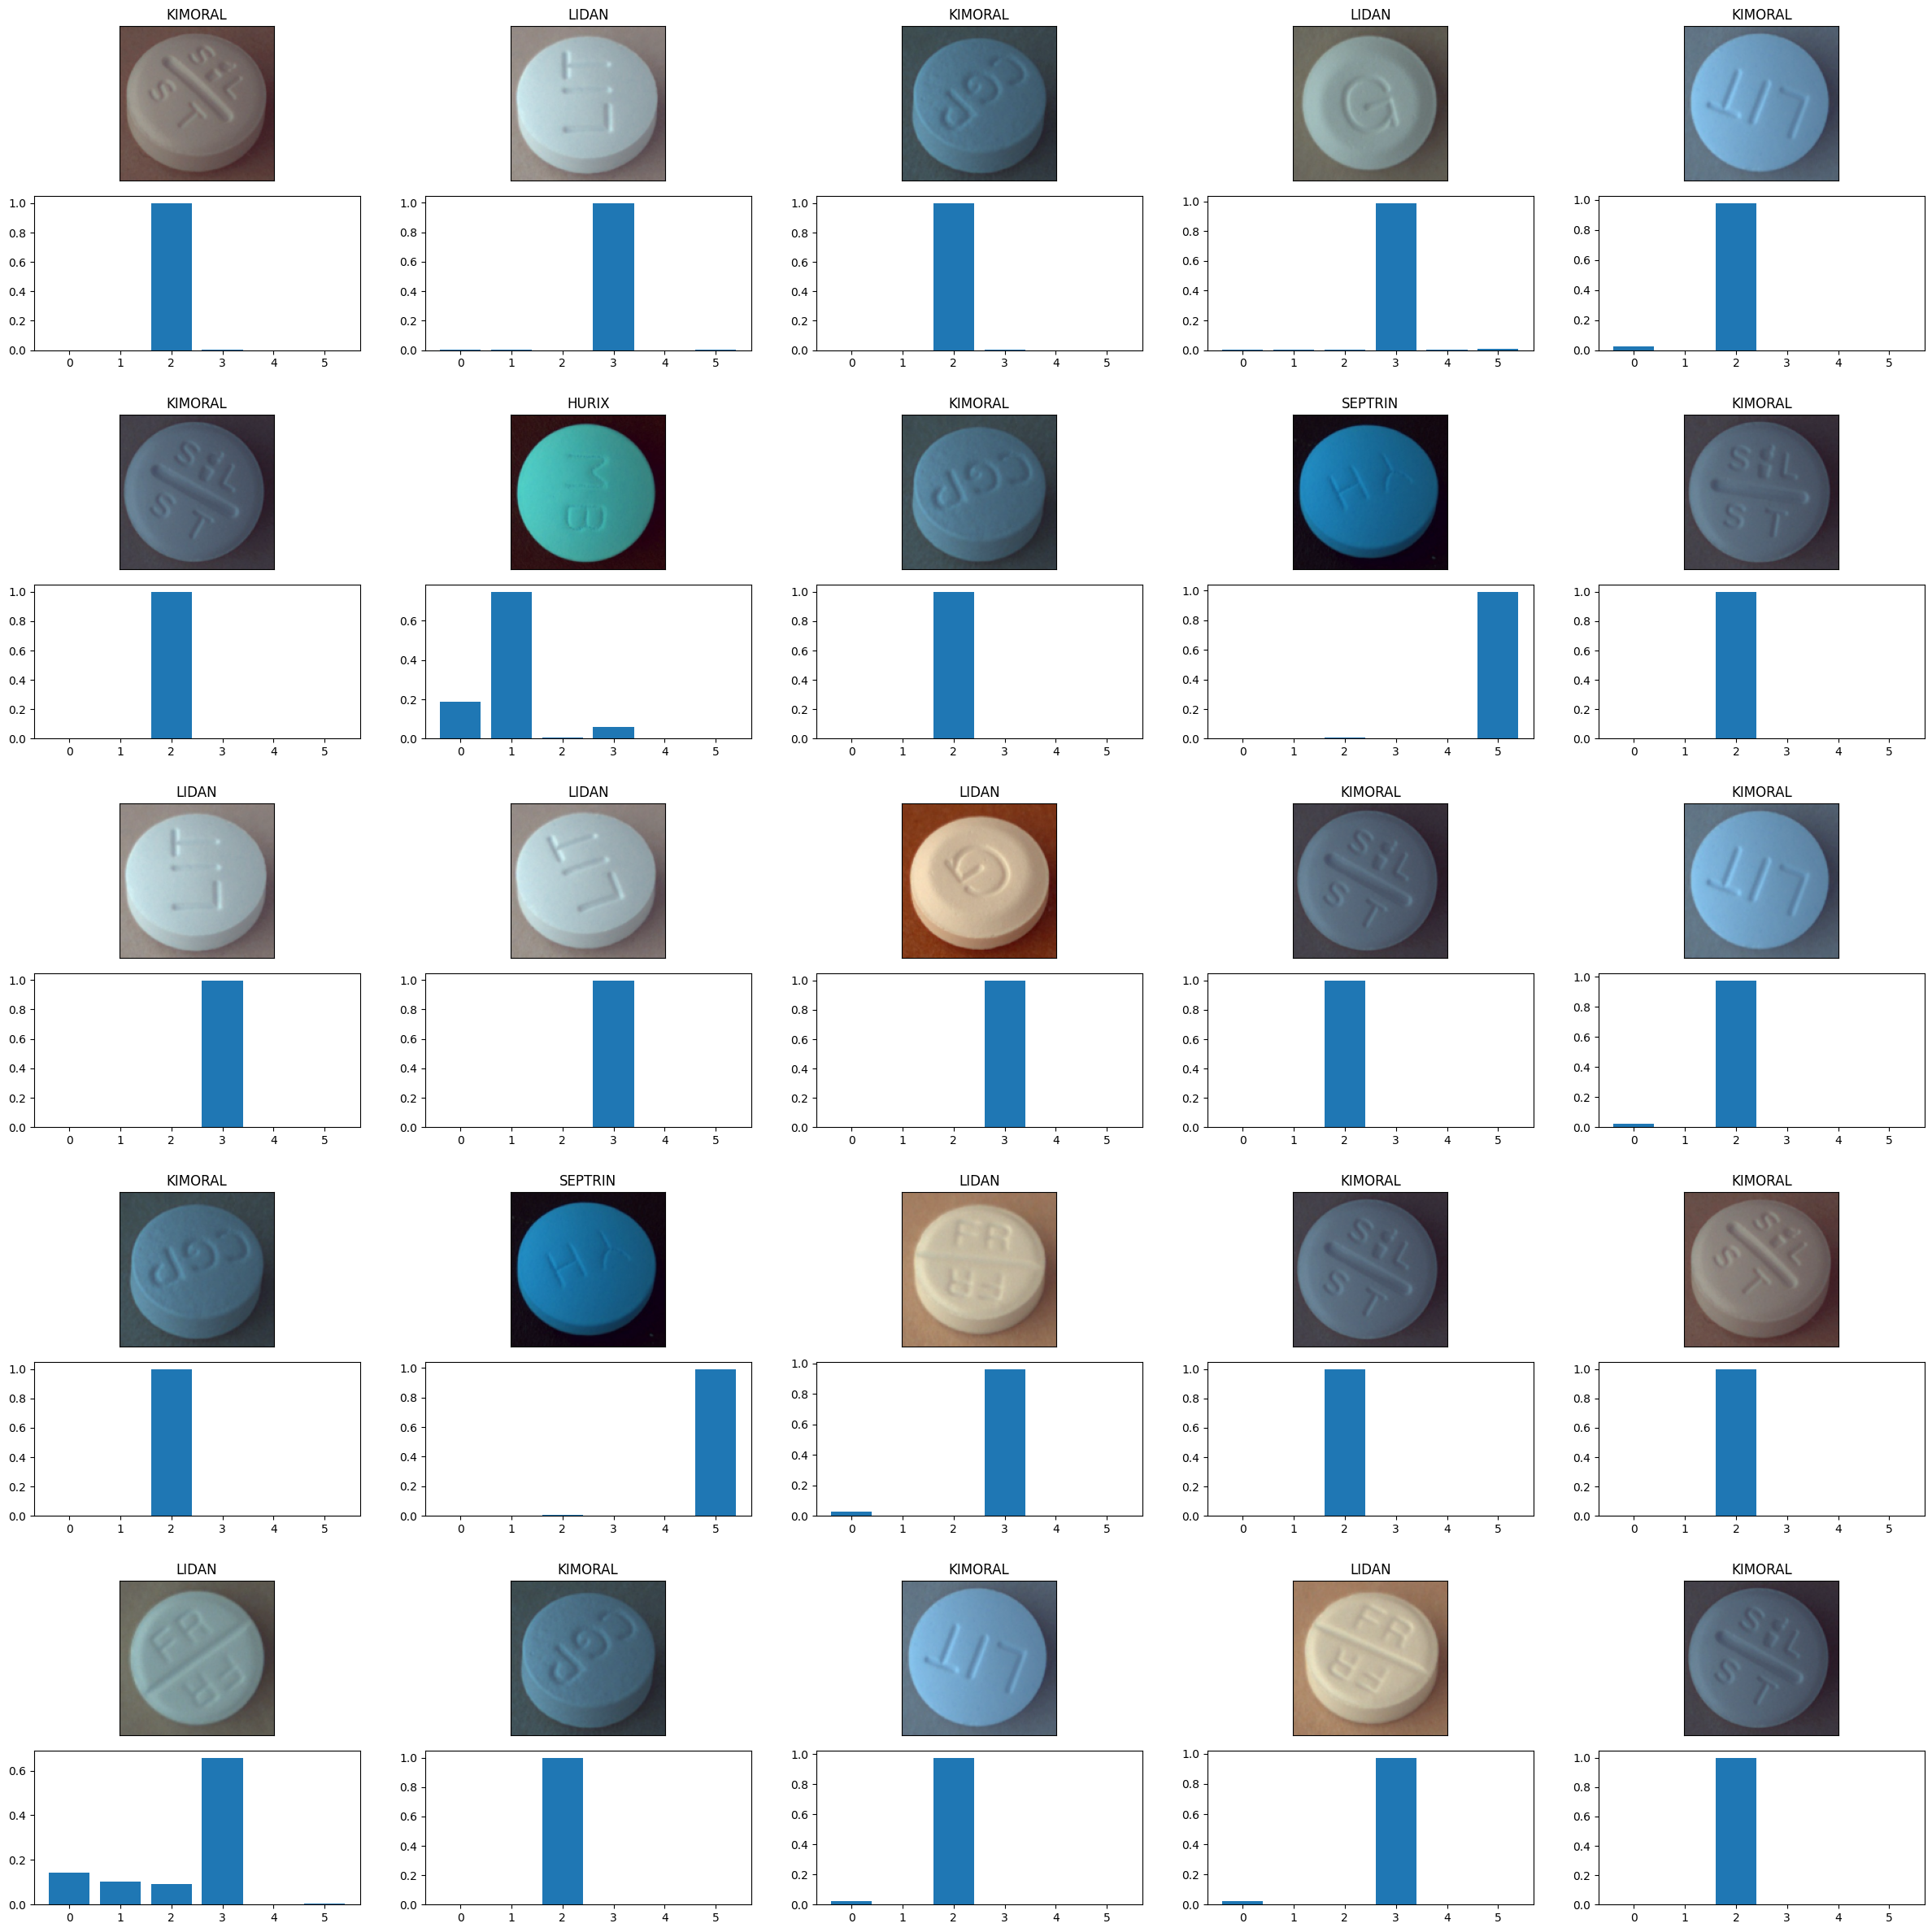

In [ ]:
# 예측한 결과는 아래와 같습니다. 이미지의 위에는 class label을 이미지 아래에는 확률을 나타냅니다.

fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images)-1)
    pred_image = np.array([pred_images[rnd_number]])

    pred_class = findKey(train_generator.class_indices, np.argmax(prediction[rnd_number]))  # 이미지의 label name 을 찾아옵니다.
    pred_prob = prediction[rnd_number].reshape(6)   # 예측된 결과(확률값)를 1차원 배열(6칸)로 reshape 합니다.
    for j in range(2):
        if (j%2) == 0:                        # 처음에는 이미지와 title(label name) 을 보여줍니다.
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:                                 # 그다음은 확률값을 그래프 형태로 보여줍니다.
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)

fig.show()